In [63]:
import baccoemu
import chainconsumer
import emcee
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plot_utils
import plotter
import utils
import run_inference as rinf
import moment_network as mn

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Results

In [6]:
plot_dir = '../plots/plots_2024-03-15'
save_plots = True

data_mode = 'emuPk'
tag_data = '_2param'
tag_errG = f'_boxsize500'
tag_inf = '_'+data_mode + tag_data + tag_errG
dir_mn = f'../data/results_moment_network/mn{tag_inf}'


In [12]:
if data_mode == 'emuPk':
    frac_train=0.4
    frac_val=0.1
    frac_test=0.5
    
elif data_mode == 'muchisimocks':
    frac_train=0.70
    frac_val=0.15
    frac_test=0.15

In [48]:
dir_data = '../data/emuPks'
rng = np.random.default_rng(42)

n_tot = 2000
theta, y, y_err, k, param_names = rinf.load_data_emuPk(dir_data, tag_data, tag_errG, rng=rng)
if n_tot < theta.shape[0]:
    theta, y, y_err = rinf.subsample_data(theta, y, y_err, n_tot, rng=rng)
n_tot, n_params = theta.shape

random_ints = np.arange(n_tot)
rng.shuffle(random_ints) #in-place

idxs_train, idxs_val, idxs_test = utils.idxs_train_val_test(random_ints, 
                                frac_train=frac_train, frac_val=frac_val, frac_test=frac_test)

theta_train, theta_val, theta_test = utils.split_train_val_test(theta, idxs_train, idxs_val, idxs_test)
y_train, y_val, y_test = utils.split_train_val_test(y, idxs_train, idxs_val, idxs_test)
y_err_train, y_err_val, y_err_test = utils.split_train_val_test(y_err, idxs_train, idxs_val, idxs_test)

(10000, 2) (10000, 30) (30,) (10000, 30)
0.4 0.1 0.5


In [49]:
param_labels = [utils.param_label_dict[param_name] for param_name in param_names]

In [50]:
theta_test_pred = np.load(f'{dir_mn}/theta_test_pred.npy')
covs_test_pred = np.load(f'{dir_mn}/covs_test_pred.npy')
print(theta_test_pred.shape, covs_test_pred.shape)

(1000, 2) (1000, 2, 2)


In [52]:
# moment_network = mn.MomentNetwork(tag_mn=tag_inf)
# moment_network.load_model_mean()
history_mean = np.load(f'{dir_mn}/model_mean_history.npy', allow_pickle=True).item()
history_cov = np.load(f'{dir_mn}/model_cov_history.npy', allow_pickle=True).item()

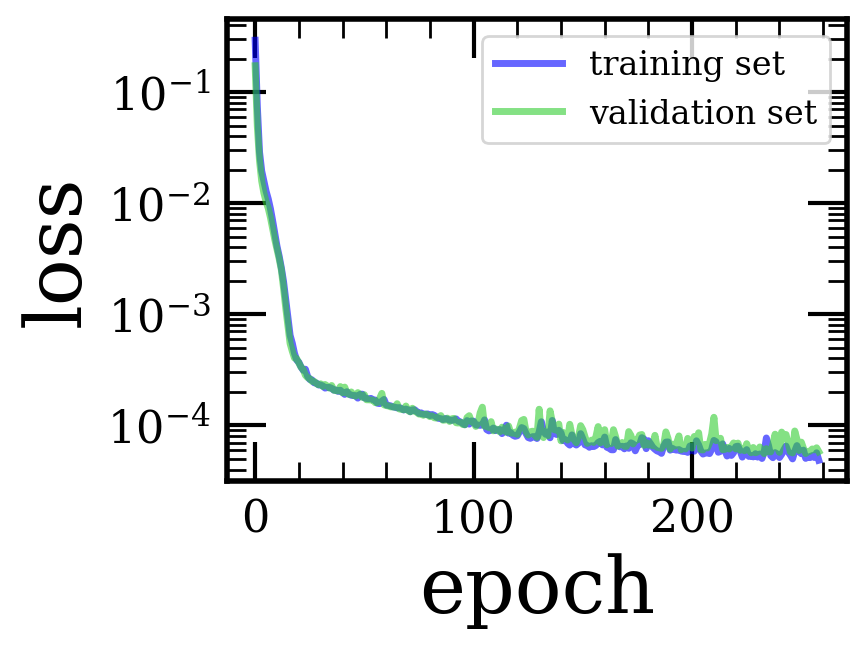

In [53]:
plotter.plot_loss(history_mean)

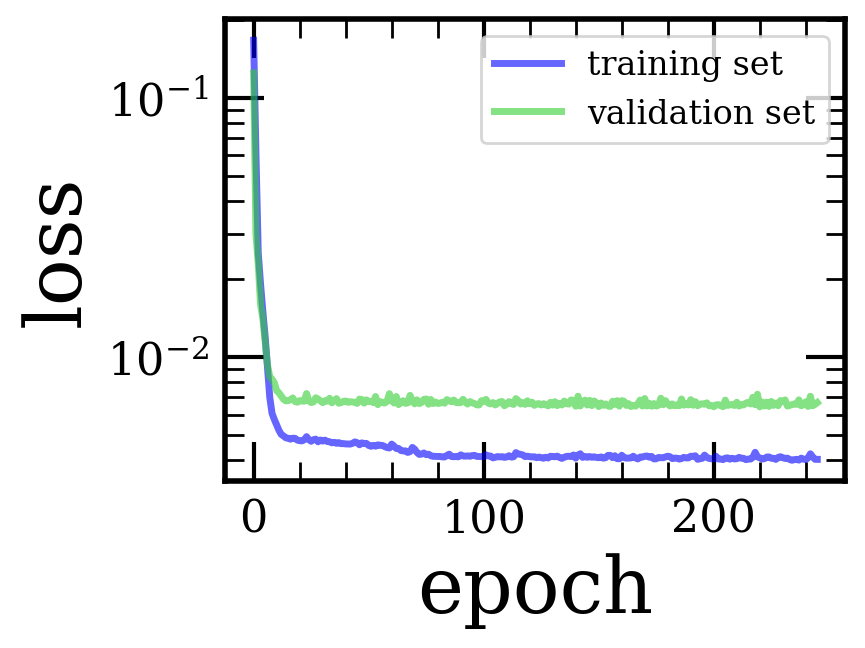

In [54]:
plotter.plot_loss(history_cov)

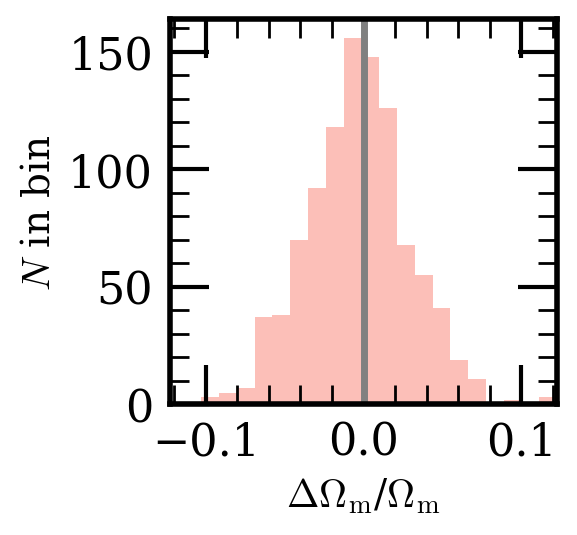

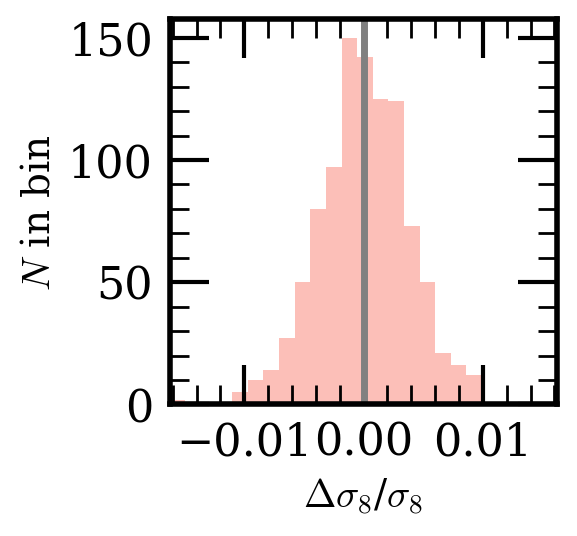

In [55]:
 plotter.plot_hists_mean(theta_test, theta_test_pred, param_labels)


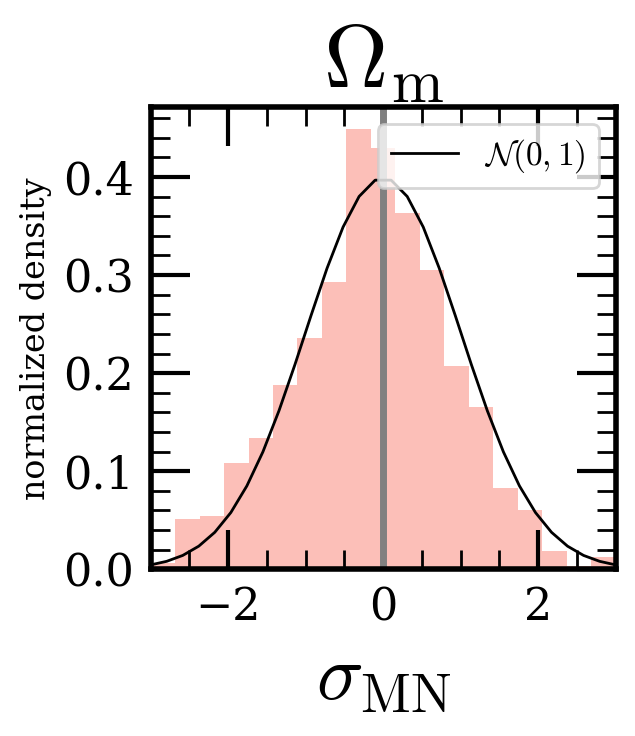

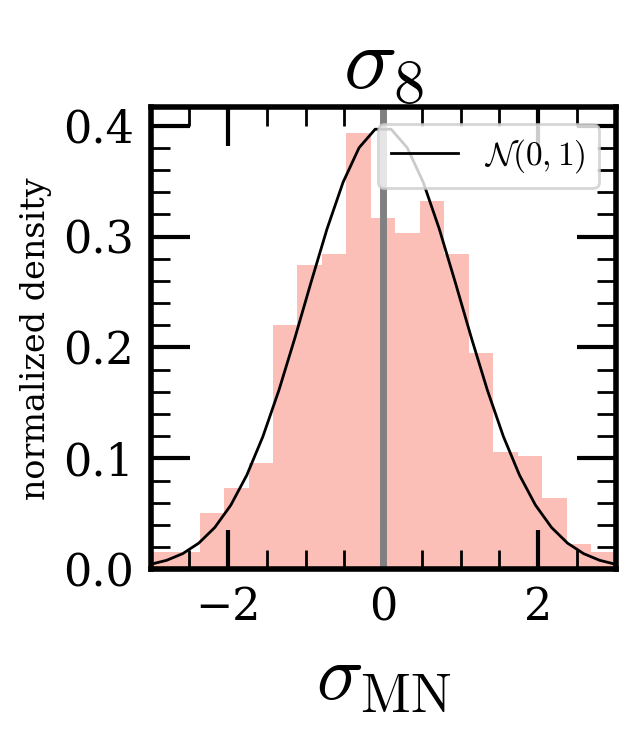

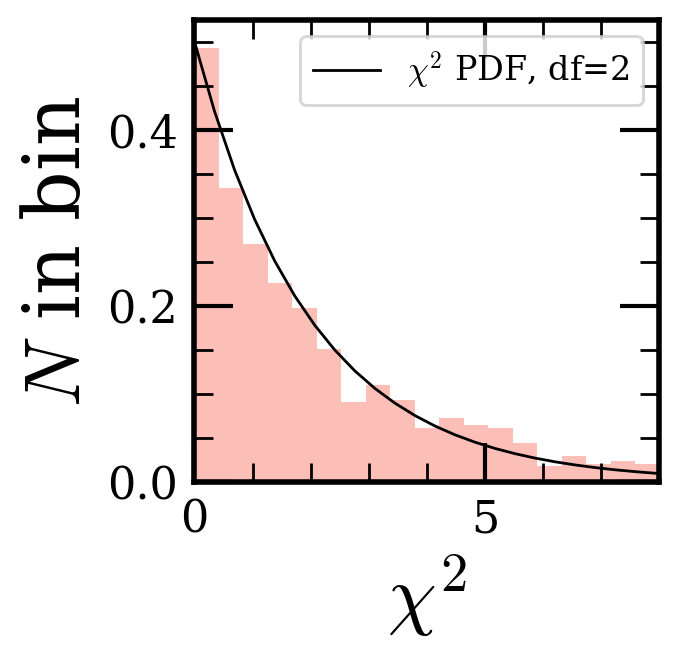

In [57]:
plotter.plot_hists_cov(theta_test, theta_test_pred, covs_test_pred, param_labels)

### Particular test sample

In [89]:
idx_test = 130

In [90]:
samples_mn = np.random.multivariate_normal(theta_test_pred[idx_test], covs_test_pred[idx_test], int(1e6))

In [96]:
dir_emcee =  f'../data/results_emcee/samplers{tag_inf}'
fn_emcee = f'{dir_emcee}/sampler_idxtest{idx_test}.npy'
reader = emcee.backends.HDFBackend(fn_emcee)

tau = reader.get_autocorr_time()
print(tau)
n_burn = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
print(n_burn, thin)
samples_emcee = reader.get_chain(discard=n_burn, flat=True, thin=thin)
print(samples_emcee.shape)

[33.91966966 31.67234044]
67 15
(2624, 2)


In [97]:
truth_loc = dict(zip(param_names, theta_test[idx_test]))
#samples_arr = [samples_mn]
methods = ['mn', 'emcee']
samples_arr = [samples_mn, samples_emcee]
smooth_arr = [1, 2]
bins_arr = [None, 10]


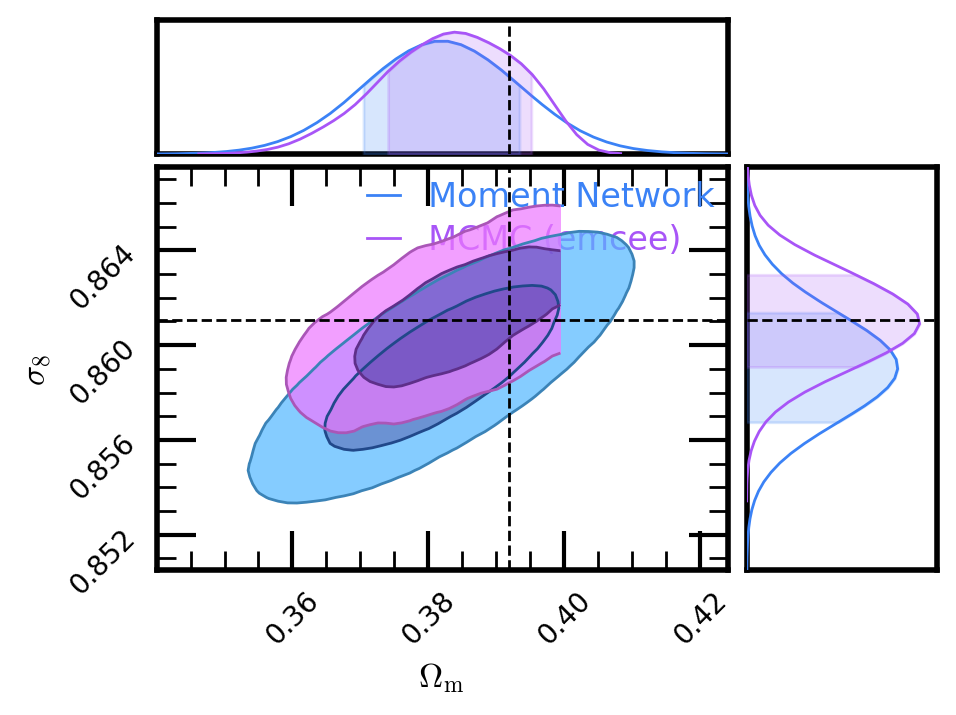

In [98]:

colors = [utils.color_dict_methods[meth] for meth in methods]
labels = [utils.label_dict_methods[meth] for meth in methods]

plotter.plot_contours(samples_arr, labels, colors, param_names, utils.param_label_dict, 
                      smooth_arr=smooth_arr, bins_arr=bins_arr,
                      truth_loc=truth_loc, extents={}, fn_save=None)
